# Age Bias Detection and Mitigation Strategies for Credit Decision Making

## Preview

This project aims to demonstrate how bias mitigation techniques can be integrated into a credit decision process using classification models. Specifically, the project showcases the use of the [AIF360](https://aif360.res.ibm.com/) toolkit to detect and reduce bias in classifiers, employing various fairness metrics and algorithms.

The classifiers are built using Logistic Regression and Random Forests, with bias detection performed through metrics such as disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and the Theil index.

Bias mitigation is implemented using techniques like reweighing (a pre-processing algorithm) to explore its effectiveness in reducing bias.

The dataset used for this project is the [German Credit Data](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

## Table of Contents

From TOC, click to land Section header.

[1. Preliminaries](#1.-Preliminaries)

[2. Dataset used](#2.-Dataset-used)

[3. Training models without debiasing](#3.-Training-models-on-original-German-credit-data)

[4. Reweighing (pre-processing bias mitigation)](#4.-Bias-mitigation-using-pre-processing-technique---Reweighing)

[5. Summary of results](#5.-Summary-of-Model-Learning-Results)

[6. Conclusion](#6.-Conclusion)

## [1.](#Table-of-Contents) Preliminaries

### Biases and Machine Learning
Machine learning models are designed to predict outcomes based on input data. For example, consider a loan application scenario where a model predicts whether an applicant will repay a loan. The model learns from a training dataset that includes historical loan applications and their outcomes, enabling it to identify patterns and generalizations. For instance, it might learn that applicants with a salary above USD 40K and outstanding debt below USD 5K are more likely to repay a loan. This approach, known as supervised machine learning, has been highly effective in various domains.

However, the patterns discovered by these models may sometimes be undesirable or even illegal. For example, a loan repayment model might find that age significantly influences repayment predictions because the training dataset shows better repayment rates for one age group over another. This presents two issues: 

1) the training dataset may not accurately represent the entire population across all age groups, and 

2) even if it does, basing decisions on an applicant's age is illegal, regardless of the data's historical accuracy.

In a real-world scenario, a financial institution might use a model to predict loan approvals. If the model unintentionally favors younger applicants due to biased training data, it could lead to discriminatory practices. AI Fairness 360 addresses this problem by providing fairness metrics and bias mitigators. Fairness metrics help identify bias in machine learning workflows, while bias mitigators can correct these biases to produce fairer outcomes.

The loan scenario is an example of illegal bias. However, not all biases in machine learning are illegal; some may simply be undesirable. For example, a company might aim to maintain a diverse customer base across all income levels and would consider it undesirable if their model disproportionately favors high-income applicants over low-income ones. Although not illegal, this bias could hinder the company's strategic goals.

These examples highlight the need for a bias detection and mitigation toolkit tailored to specific biases of interest. The toolkit must identify the protected attributes, such as race or age, that are critical to ensuring fairness.

### The Machine Learning Workflow
To understand how bias can enter a machine learning model, it is essential to review the basics of supervised machine learning. The process begins with a training dataset, which contains instances where each instance includes features and their corresponding correct predictions. A machine learning algorithm trains on this dataset to produce a model, which can then make predictions on new data. A separate test dataset, containing similar instances, is used to evaluate the model's accuracy. Often, these training and test datasets are derived from a single dataset, split into two parts using a random partitioning algorithm.

Bias can be introduced at any stage of this process. The training dataset might be biased, favoring certain types of instances. The algorithm itself could be biased, producing models that disproportionately weigh specific features. The test dataset might also be biased, reflecting biased expectations for correct answers. These stages—training data, algorithm, and test data—represent critical points for detecting and mitigating bias. In the AI Fairness 360 toolkit, these are referred to as pre-processing, in-processing, and post-processing stages.

### AI Fairness 360
Now, we will use AI Fairness 360 (aif360) to detect and mitigate bias in a machine learning model. We will work with the German credit dataset, which will be split into training and test sets. The goal is to build a model that predicts whether an applicant should receive credit based on various features from a typical credit application. The protected attribute in this scenario is "Age," with "1" (age 25 and older) representing the privileged group and "0" (younger than 25) representing the unprivileged group.

In this project, we will begin by checking for bias in the initial training data, apply bias mitigation techniques, and then re-evaluate the model.

## [2.](#Table-of-Contents) Dataset used

The German Credit dataset, also known as the Statlog German Credit Data, is a prominent dataset in machine learning, widely used for binary classification tasks and fairness studies. It contains 1,000 instances with 20 features, including both categorical and numerical attributes, aimed at predicting whether an individual poses a "good" or "bad" credit risk. 

Key features include credit history, purpose, credit amount, employment status, savings, and age. The dataset is particularly useful for exploring the impact of sensitive attributes like age and gender on credit decisions. Age is often categorized into "≥ 25" (privileged) and "< 25" (unprivileged) groups, making it a focal point for studies on bias and fairness.

Researchers use the German Credit dataset to build and evaluate credit scoring models, detecting and mitigating biases that may arise in the decision-making process. Common fairness metrics such as disparate impact, average odds difference, and statistical parity difference are applied to assess the fairness of models. 

The dataset is a critical tool for understanding and addressing ethical concerns in machine learning, especially in financial services, where unbiased decision-making is crucial. Its applications extend to testing various bias detection and mitigation techniques, making it indispensable for research in AI fairness and responsible AI deployment.

## [3.](#Table-of-Contents) Training models on original German credit data

### 3.1 Import Statements

The first step is to import the necessary packages. We begin by importing key components from the `aif360` package, including the `GermanDataset`, metrics for bias detection, and the classes required for implementing bias mitigation algorithms. These imports are essential for analyzing and addressing bias in our machine learning model.

In [2]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import pandas as pd
import numpy as np
np.random.seed(0)

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

from optimize_hyperparams import optimize_hyperparameters
from plot_utils import plot_fairness_metrics, plot_comparative_fairness_metrics

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer
from aif360.algorithms.preprocessing import Reweighing


### 3.2 Load and Split Dataset into Train, Validation, and Test Sets

We begin by loading the dataset, with age set as the protected attribute. Next, we split the dataset into three parts: training (50%), validation (30%), and testing (20%). We also define two variables to represent the privileged group (age ≥ 25) and the unprivileged group (age < 25). This setup allows us to evaluate and mitigate bias across different stages of model development.

In [4]:
def load_and_split_dataset(protected_attribute, privileged_class, features_to_drop, split_ratios, shuffle=True):
    """
    Load the dataset, process it by setting the protected attribute and privileged class, 
    and split it into training, validation, and test sets.

    Parameters:
    - protected_attribute (str): The attribute to be protected (e.g., 'age').
    - privileged_class (list): The conditions defining the privileged class (e.g., [lambda x: x >= 25]).
    - features_to_drop (list): List of features to drop from the dataset (e.g., ['personal_status', 'sex']).
    - split_ratios (list): List of ratios for splitting the dataset (e.g., [0.5, 0.8]).
    - shuffle (bool): Whether to shuffle the dataset before splitting (default is True).

    Returns:
    - tuple: Three datasets (train, validation, test) as per the split ratios.
    """
    # Load the German dataset with specified parameters
    dataset = GermanDataset(
        protected_attribute_names=[protected_attribute],
        privileged_classes=[privileged_class],
        features_to_drop=features_to_drop
    )
    
    # Split the dataset into training, validation, and test sets
    dataset_train, dataset_val, dataset_test = dataset.split(split_ratios, shuffle=shuffle)
    
    return dataset, dataset_train, dataset_val, dataset_test

In [7]:
def summarize_dataset(train=None, val=None, test=None):
    """
    Summarizes the provided datasets by displaying their shapes, labels, and protected attributes.

    Parameters:
    - train: The training dataset.
    - val: The validation dataset.
    - test: The test dataset.
    """
    
    if train is not None:
        display(Markdown("#### Training Dataset Shape"))
        print(train.features.shape)
    
    if val is not None:
        display(Markdown("#### Validation Dataset Shape"))
        print(val.features.shape)
    
    if test is not None:
        display(Markdown("#### Test Dataset Shape"))
        print(test.features.shape)
        
        display(Markdown("#### Favorable and Unfavorable Labels"))
        print(f"Favorable Label: {test.favorable_label}, Unfavorable Label: {test.unfavorable_label}")
        
        display(Markdown("#### Protected Attribute Names"))
        print(test.protected_attribute_names)
        
        display(Markdown("#### Privileged and Unprivileged Protected Attribute Values"))
        print(f"Privileged: {test.privileged_protected_attributes}, Unprivileged: {test.unprivileged_protected_attributes}")
        
        display(Markdown("#### Dataset Feature Names"))
        print(test.feature_names)
    else:
        print("Test dataset is required for summarization.")

In [5]:
protected_attribute = 'age'
privileged_class = lambda x: x >= 25
features_to_drop = ['personal_status', 'sex']
split_ratios = [0.5, 0.8]

dataset_orig, dataset_orig_train, dataset_orig_val, dataset_orig_test = load_and_split_dataset(
    protected_attribute,
    privileged_class,
    features_to_drop,
    split_ratios
)

Display German credit dataset details

In [6]:
# Check the feature names of the the original dataset
print(dataset_orig.feature_names)
# Check the shape of the the original dataset
print(f"Dataset shape dataset_orig: {dataset_orig.features.shape}")

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_wor

In [8]:
summarize_dataset(dataset_orig_train, dataset_orig_val, dataset_orig_test)

#### Training Dataset Shape

(500, 57)


#### Validation Dataset Shape

(300, 57)


#### Test Dataset Shape

(200, 57)


#### Favorable and Unfavorable Labels

Favorable Label: 1.0, Unfavorable Label: 2.0


#### Protected Attribute Names

['age']


#### Privileged and Unprivileged Protected Attribute Values

Privileged: [array([1.])], Unprivileged: [array([0.])]


#### Dataset Feature Names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_wor

### 3.3 Evaluate Fairness Metrics on the Original Training Dataset

We assess the fairness of the original training dataset by calculating and displaying key metrics, such as Disparate Impact and the difference in mean outcomes between privileged and unprivileged groups. The evaluation is adaptable and can be applied to various attributes beyond age, depending on the specific fairness criteria under review.

In [9]:
def define_privileged_unprivileged_groups(attribute_name, privileged_attribute, unprivileged_attribute):
    """
    Defines privileged and unprivileged groups based on the specified attribute.

    Parameters:
    - attribute_name (str): The name of the attribute (e.g., 'age', 'gender').
    - privileged_attribute: The value that defines the privileged group (e.g., 1 for 'age' >= 25).
    - unprivileged_attribute: The value that defines the unprivileged group (e.g., 0 for 'age' < 25).

    Returns:
    - privileged_groups (list): A list of dictionaries defining the privileged group.
    - unprivileged_groups (list): A list of dictionaries defining the unprivileged group.
    """
    
    privileged_groups = [{attribute_name: privileged_attribute}]
    unprivileged_groups = [{attribute_name: unprivileged_attribute}]
    
    return privileged_groups, unprivileged_groups

In [11]:
def evaluate_fairness_metrics(dataset, privileged_groups, unprivileged_groups, title=None, attribute_name='age'):
    """
    Evaluates and displays fairness metrics for the given dataset, focusing on disparate impact and 
    the difference in mean outcomes between privileged and unprivileged groups.

    Parameters:
    - dataset: The dataset to evaluate (e.g., training, validation, or test).
    - privileged_groups: A list of dictionaries defining the privileged group (e.g., [{'age': 1}]).
    - unprivileged_groups: A list of dictionaries defining the unprivileged group (e.g., [{'age': 0}]).
    - attribute_name: The name of the attribute to evaluate (default is 'age').

    Returns:
    - None
    """
    # Print shapes of features and labels
    print(f"Feature shape: {dataset.features.shape}")
    print(f"Label shape: {dataset.labels.shape}")
    
    # Ensure consistency between features and labels
    if len(dataset.features) != len(dataset.labels):
        raise ValueError(print(f"Inconsistent number of features ({len(dataset.features)}) and labels ({len(dataset.labels)})."))
    
    # Calculate fairness metrics
    metric = BinaryLabelDatasetMetric(dataset, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    
    # Explain and display the metrics
    explainer = MetricTextExplainer(metric)
    display(Markdown(f"#### Metrics for {title} dataset (evaluating {attribute_name})"))
    print("Disparate Impact:", explainer.disparate_impact())
    print(f"Difference in mean outcomes between unprivileged and privileged groups = {metric.mean_difference():.4f}")

In [10]:
attribute_name = 'age'
privileged_attribute = 1  # For example, 'age' >= 25
unprivileged_attribute = 0  # For example, 'age' < 25

privileged_groups, unprivileged_groups = define_privileged_unprivileged_groups(attribute_name, privileged_attribute, unprivileged_attribute)

print("Privileged Groups:", privileged_groups)
print("Unprivileged Groups:", unprivileged_groups)

Privileged Groups: [{'age': 1}]
Unprivileged Groups: [{'age': 0}]


In [12]:
evaluate_fairness_metrics(dataset_orig_train, privileged_groups, unprivileged_groups, title='original training', attribute_name='age')

Feature shape: (500, 57)
Label shape: (500, 1)


#### Metrics for original training dataset (evaluating age)

Disparate Impact: Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.798234552332913
Difference in mean outcomes between unprivileged and privileged groups = -0.1458


#### Analysis: 

The metrics indicate bias against the unprivileged group (younger individuals). A Disparate Impact of 0.798 suggests lower favorable outcomes for them, slightly below the fairness threshold of 0.8. The negative mean difference (-0.1458) further confirms this bias, signaling a need for mitigation.

### 3.4. Create Functions for ML Training and Evaluation

In [13]:
def train_model(dataset, model, fit_params=None):
    """
    Trains a machine learning model on the given dataset with optional fit parameters.

    Parameters:
    - dataset: The dataset to use for training, which should include features, labels, and instance_weights.
    - model: The machine learning model to be used.
    - fit_params: Optional dictionary of fit parameters (e.g., sample weights) to be passed during model training.

    Returns:
    - The trained model.
    """
    
    # Create a pipeline with standard scaling and the given model
    pipeline = make_pipeline(StandardScaler(), model)
    
    # Train the model
    trained_model = pipeline.fit(dataset.features, dataset.labels.ravel(), **(fit_params or {}))
    
    return trained_model

In [14]:
def perform_bias_detection(dataset_orig_test, trained_orig_model, title=None):

    # Define privileged (male) and unprivileged (female) groups
    privileged_groups = [{'age': 1}] 
    unprivileged_groups = [{'age': 0}] 

    test_pred = trained_orig_model.predict(dataset_orig_test.features)

    # Convert the predicted labels to a BinaryLabelDataset
    dataset_pred = dataset_orig_test.copy()
    dataset_pred.labels = test_pred.reshape(-1, 1)  

    # ClassificationMetric
    metric = ClassificationMetric(dataset_orig_test, dataset_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    fairness_metrics = {
        "Demographic Parity Difference": metric.statistical_parity_difference(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Average Odds Difference": metric.average_odds_difference(),
        "Disparate Impact": metric.disparate_impact(),
        "Theil Index": metric.theil_index()
    }

    display(Markdown(f"#### Fairness Metrics for {title}"))
    for key, value in fairness_metrics.items():
        print(f"{key}: {value:.3f}")
    
    return fairness_metrics

### 3.5. Applying a Logistic Regression (LR) classifier on original data
#### 3.5.1. Training LR model on original data

In [15]:
# Optimizing hyperparameters for Logistic Regression
dataset = dataset_orig_train

param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__max_iter': [500, 1000, 2000],
    'logisticregression__solver': ['liblinear', 'saga']
}

lr_model = LogisticRegression(random_state=42)
fit_params_lr = {'logisticregression__sample_weight': dataset.instance_weights}

best_lr_model, best_lr_params = optimize_hyperparameters(dataset, lr_model, param_grid_lr, fit_params_lr)

print(f"Best Logistic Regression Model: {best_lr_model}")
print(f"Best Hyperparameters for Logistic Regression: {best_lr_params}")

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Logistic Regression Model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=500, random_state=42,
                                    solver='liblinear'))])
Best Hyperparameters for Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 500, 'logisticregression__solver': 'liblinear'}


In [16]:
dataset = dataset_orig_train
lr_model = LogisticRegression(solver='liblinear', C=0.1, max_iter=500, random_state=42)
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_model = train_model(dataset, lr_model, fit_params)

#### 3.5.2. Validating LR model on original data

In [17]:
val_pred_lr = lr_orig_model.predict(dataset_orig_val.features)
accuracy_lr = accuracy_score(dataset_orig_val.labels, val_pred_lr)
display(Markdown("#### Performance Metrics for LR model on original validation data"))
print(f"Validation Accuracy: {accuracy_lr:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_val.labels, val_pred_lr))

#### Performance Metrics for LR model on original validation data

Validation Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

         1.0       0.79      0.88      0.83       213
         2.0       0.59      0.44      0.50        87

    accuracy                           0.75       300
   macro avg       0.69      0.66      0.67       300
weighted avg       0.73      0.75      0.74       300



In [18]:
fairness_metrics_lr_val = perform_bias_detection(dataset_orig_val, lr_orig_model, "LR Val data")

#### Fairness Metrics for LR Val data

Demographic Parity Difference: -0.203
Equal Opportunity Difference: -0.224
Average Odds Difference: -0.136
Disparate Impact: 0.752
Theil Index: 0.136


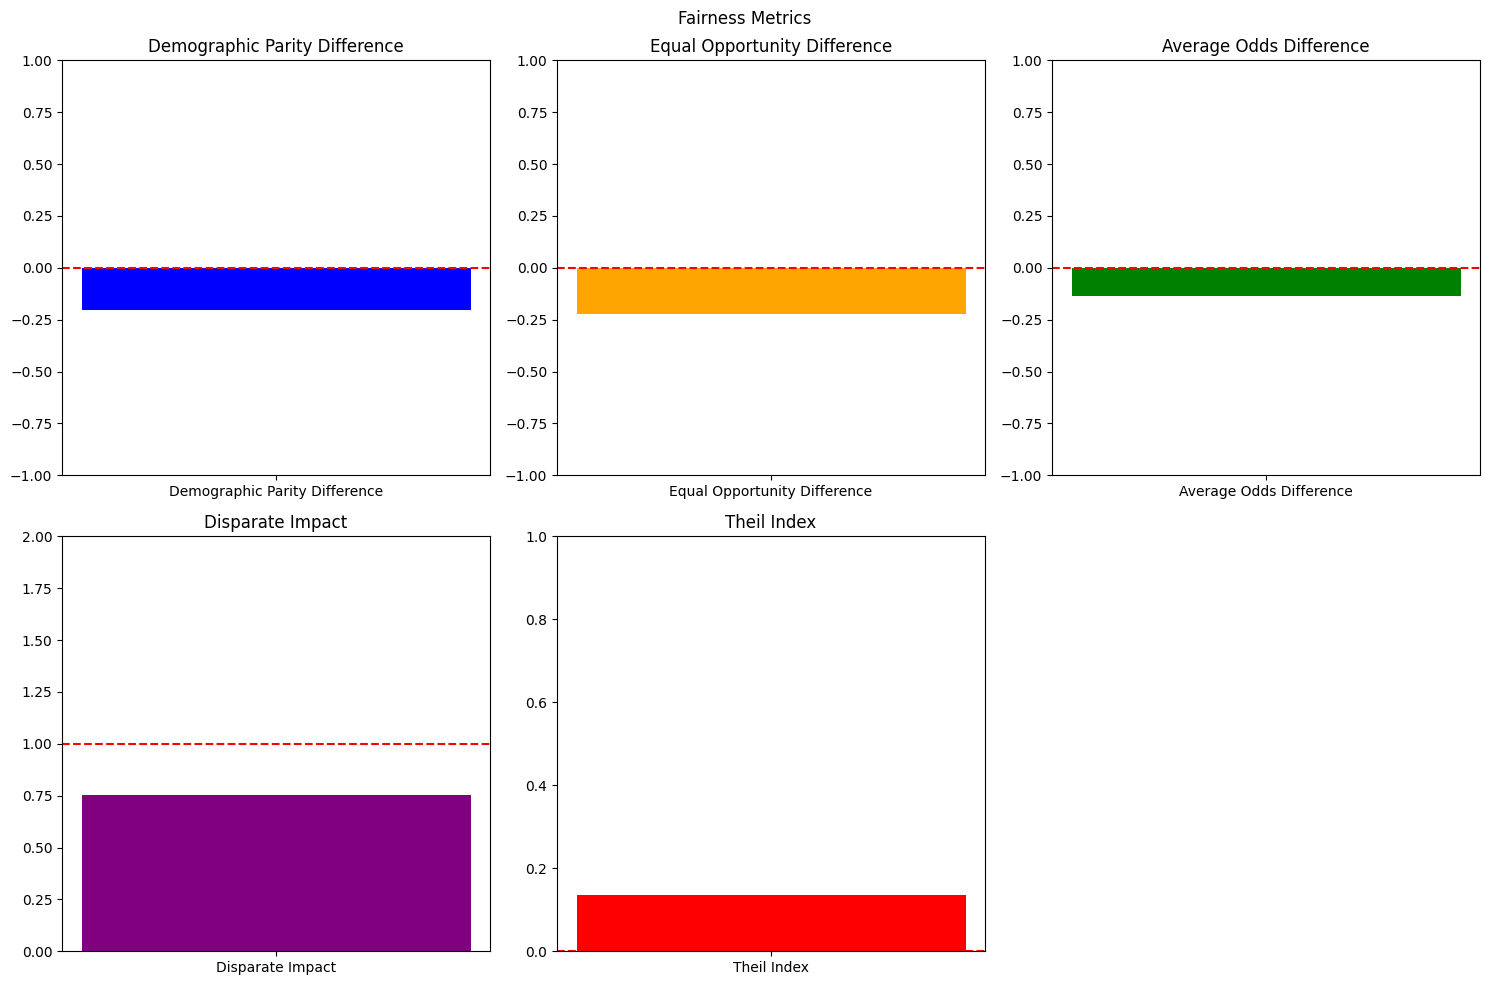

In [19]:
plot_fairness_metrics(fairness_metrics_lr_val)

#### Analysis

The fairness metrics for Logistic Regression on the validation set for age show bias:

- **Demographic Parity Difference** (-0.203): Fewer favorable outcomes for individuals under 25.
- **Equal Opportunity Difference** (-0.224) and **Average Odds Difference** (-0.136): The model is less accurate for the younger (unprivileged) group.
- **Disparate Impact** (0.752): The unprivileged group receives only 75.2% of favorable outcomes compared to the older (privileged) group.
- **Theil Index** (0.136): Indicates moderate inequality in predictions.

This analysis suggests age-related bias, disadvantaging younger individuals.

#### 3.5.3. Testing LR model on original data

In [20]:
test_pred_lr = lr_orig_model.predict(dataset_orig_test.features)
test_accuracy_lr = accuracy_score(dataset_orig_test.labels, test_pred_lr)
display(Markdown("#### Performance Metrics for LR model on original test data"))
print(f"Test Accuracy: {test_accuracy_lr:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_test.labels, test_pred_lr))

#### Performance Metrics for LR model on original test data

Test Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

         1.0       0.77      0.89      0.83       137
         2.0       0.64      0.43      0.51        63

    accuracy                           0.74       200
   macro avg       0.71      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



In [21]:
fairness_metrics_lr_test = perform_bias_detection(dataset_orig_test, lr_orig_model, "LR Test data")

#### Fairness Metrics for LR Test data

Demographic Parity Difference: -0.185
Equal Opportunity Difference: -0.194
Average Odds Difference: -0.171
Disparate Impact: 0.773
Theil Index: 0.126


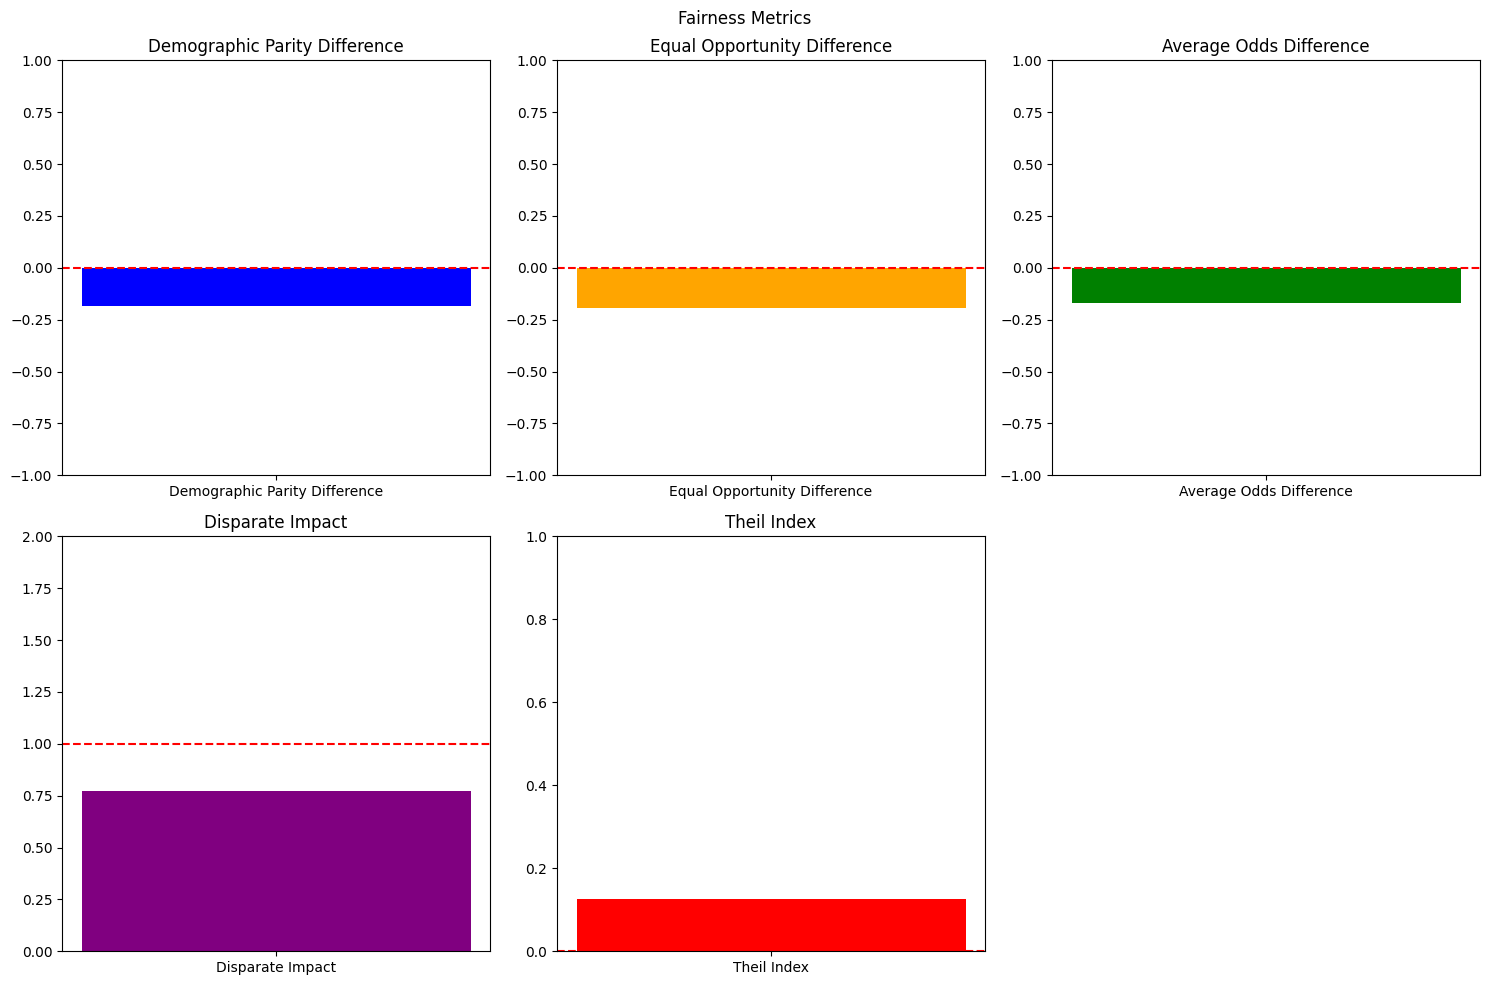

In [22]:
plot_fairness_metrics(fairness_metrics_lr_test)

#### Analysis:

The fairness metrics for Logistic Regression on the test set for age show bias:

- **Demographic Parity Difference** (-0.185): Indicates fewer favorable outcomes for individuals under 25.
- **Equal Opportunity Difference** (-0.194) and **Average Odds Difference** (-0.171): The model is less accurate for the younger (unprivileged) group.
- **Disparate Impact** (0.773): The unprivileged group receives 77.3% of the favorable outcomes compared to the older (privileged) group.
- **Theil Index** (0.126): Reflects moderate inequality in predictions.

Overall, these metrics reveal age-related bias, disadvantaging younger individuals.

### 3.6. Applying a Random Forest (RF) classifier on original data
#### 3.6.1. Training RF model on original data

In [29]:
dataset = dataset_orig_train

# Optimizing hyperparameters for Random Forest
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200, 300, 500],
    'randomforestclassifier__min_samples_leaf': [1, 2, 5, 7],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40]
}

rf_model = RandomForestClassifier(random_state=42)
fit_params_rf = {'randomforestclassifier__sample_weight': dataset.instance_weights}

best_rf_model, best_rf_params = optimize_hyperparameters(dataset, rf_model, param_grid_rf, fit_params_rf)

print(f"Best Random Forest Model: {best_rf_model}")
print(f"Best Hyperparameters for Random Forest: {best_rf_params}")

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best Random Forest Model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_estimators=500,
                                        random_state=42))])
Best Hyperparameters for Random Forest: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 500}


In [23]:
dataset = dataset_orig_train
rf_model = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=1, random_state=42)
fit_params_rf = {'randomforestclassifier__sample_weight': dataset.instance_weights}

rf_orig_model = train_model(dataset, rf_model, fit_params_rf)

#### 3.6.2. Validating RF model on original data

In [24]:
val_pred_rf = rf_orig_model.predict(dataset_orig_val.features)
accuracy_rf = accuracy_score(dataset_orig_val.labels, val_pred_rf)
display(Markdown("#### Performance Metrics for RF model on original validation data"))    
print(f"Validation Accuracy: {accuracy_rf:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_val.labels, val_pred_rf))

#### Performance Metrics for RF model on original validation data

Validation Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

         1.0       0.77      0.92      0.84       213
         2.0       0.63      0.33      0.44        87

    accuracy                           0.75       300
   macro avg       0.70      0.63      0.64       300
weighted avg       0.73      0.75      0.72       300



In [25]:
fairness_metrics_rf_val = perform_bias_detection(dataset_orig_val, rf_orig_model, "RF Val data")

#### Fairness Metrics for RF Val data

Demographic Parity Difference: -0.060
Equal Opportunity Difference: -0.136
Average Odds Difference: 0.010
Disparate Impact: 0.930
Theil Index: 0.108


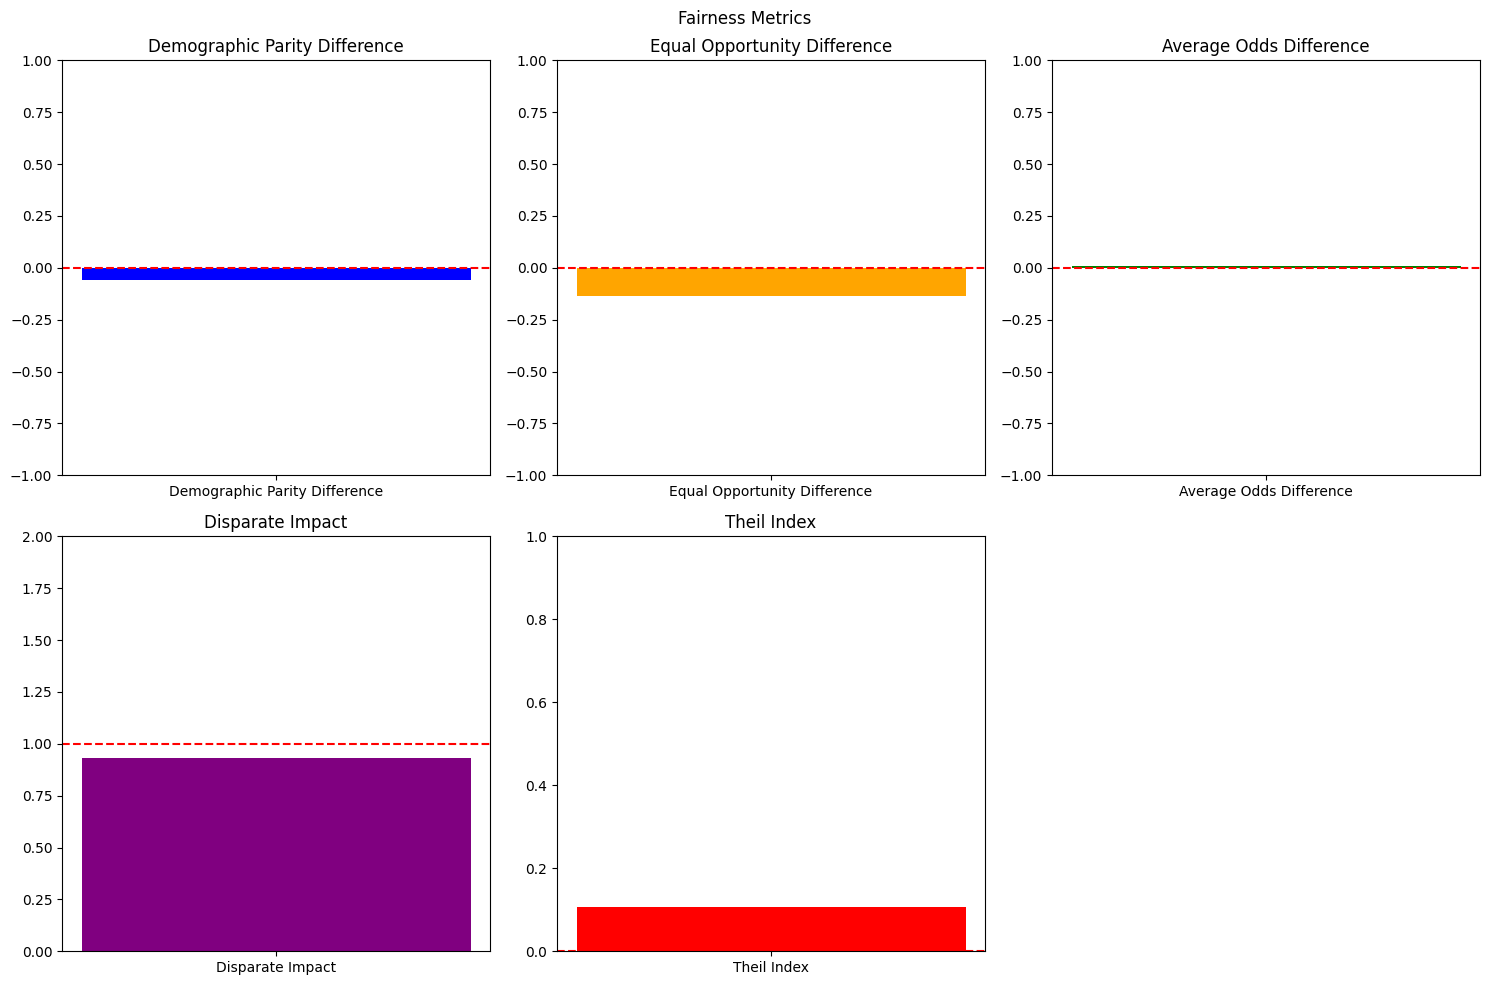

In [26]:
plot_fairness_metrics(fairness_metrics_rf_val)

#### Analysis:

The fairness metrics for Random Forest on the validation set for age suggest minor bias:

- **Demographic Parity Difference** (-0.060): Slightly fewer favorable outcomes for individuals under 25.
- **Equal Opportunity Difference** (-0.136): The model is less accurate for younger (unprivileged) individuals.
- **Average Odds Difference** (0.010): Indicates almost balanced odds for both groups.
- **Disparate Impact** (0.930): The unprivileged group receives 93% of favorable outcomes compared to the privileged group.
- **Theil Index** (0.108): Shows moderate inequality in predictions.

These metrics suggest slight age-related bias, with better fairness compared to some other models.

#### 3.6.3. Testing RF model on original data

In [27]:
test_pred_rf = rf_orig_model.predict(dataset_orig_test.features)
test_accuracy_rf = accuracy_score(dataset_orig_test.labels, test_pred_rf)
display(Markdown("#### Performance Metrics for RF model on original test data"))
print(f"Test Accuracy: {test_accuracy_rf:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_test.labels, test_pred_rf))

#### Performance Metrics for RF model on original test data

Test Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

         1.0       0.78      0.92      0.84       137
         2.0       0.71      0.43      0.53        63

    accuracy                           0.77       200
   macro avg       0.74      0.67      0.69       200
weighted avg       0.76      0.77      0.75       200



In [28]:
fairness_metrics_rf_test = perform_bias_detection(dataset_orig_test, rf_orig_model, "RF Test data")

#### Fairness Metrics for RF Test data

Demographic Parity Difference: -0.209
Equal Opportunity Difference: -0.163
Average Odds Difference: -0.221
Disparate Impact: 0.751
Theil Index: 0.104


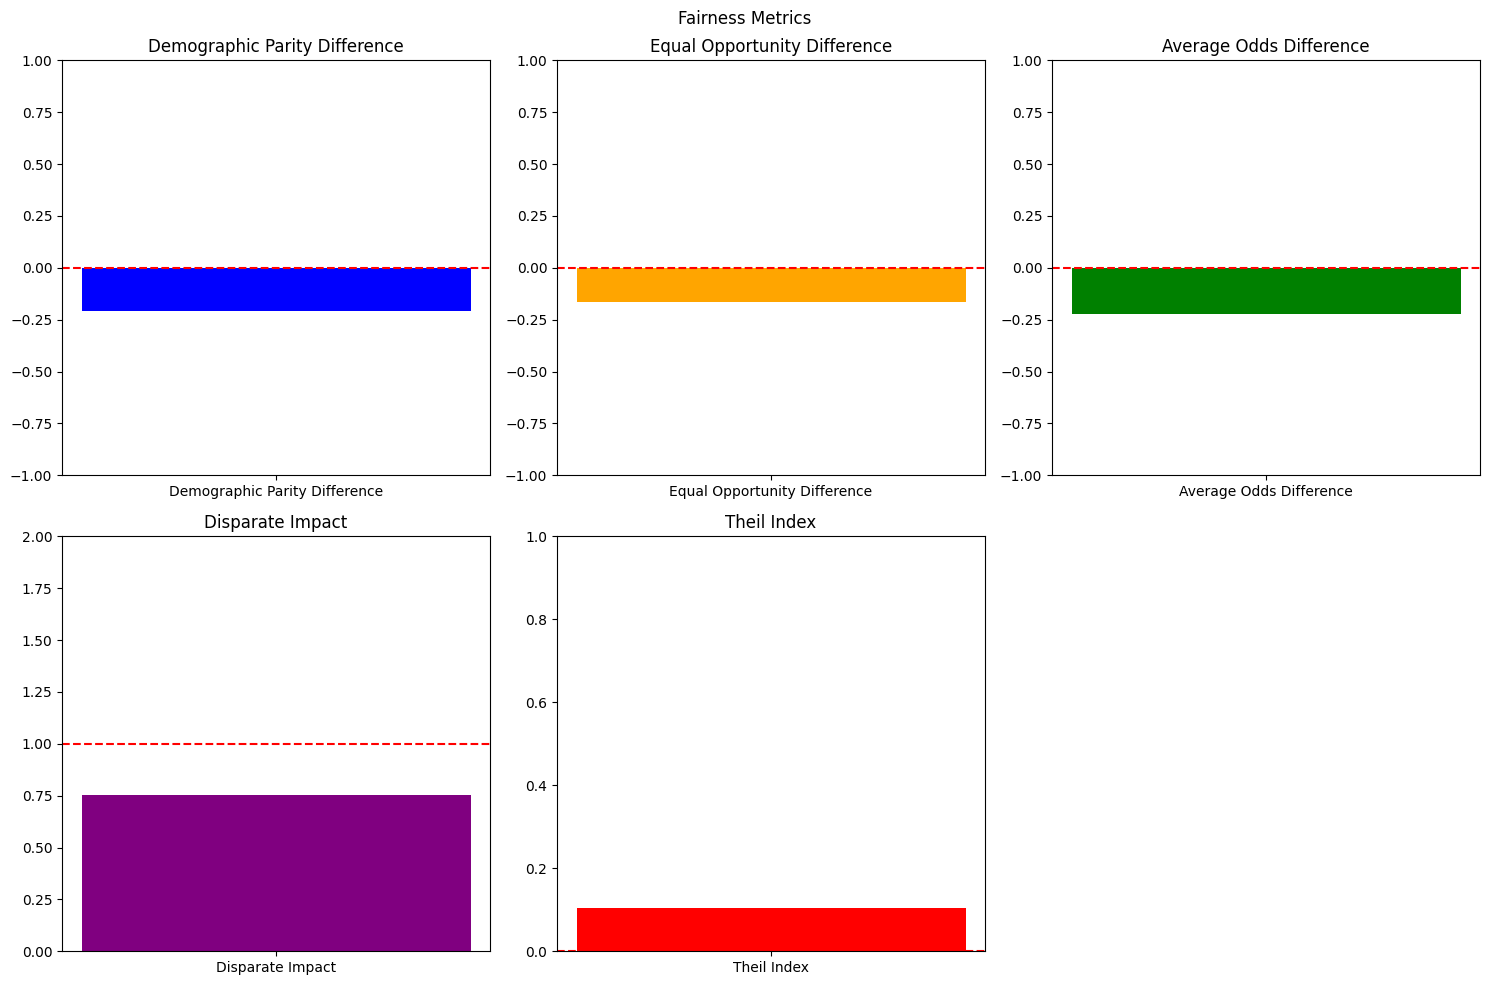

In [29]:
plot_fairness_metrics(fairness_metrics_rf_test)

#### Analysis

The fairness metrics for Random Forest on the test set for age reveal significant bias:

- **Demographic Parity Difference** (-0.209): Indicates fewer favorable outcomes for individuals under 25.
- **Equal Opportunity Difference** (-0.163) and **Average Odds Difference** (-0.221): The model is less accurate for the younger (unprivileged) group.
- **Disparate Impact** (0.751): The unprivileged group receives 75.1% of favorable outcomes compared to the privileged group.
- **Theil Index** (0.104): Reflects moderate inequality in predictions.

These metrics indicate age-related bias, disadvantaging younger individuals, especially in parity and opportunity.

## [4.](#Table-of-Contents) Bias mitigation using pre-processing technique - Reweighing

### 4.1 Mitigating Bias by Transforming the Original Dataset

The previous evaluation revealed that the privileged group received more favorable outcomes in the training dataset, which is not ideal. To address this, we will apply bias mitigation to the training data. This approach, known as _pre-processing_ mitigation, is implemented before model creation.

AI Fairness 360 provides several pre-processing algorithms for bias mitigation. We will use the Reweighing algorithm, available in the `Reweighing` class of the `aif360.algorithms.preprocessing` package. This algorithm adjusts the dataset to create a more balanced distribution of positive outcomes between the privileged and unprivileged groups.

Next, we apply the fit and transform methods to the training dataset, resulting in a newly transformed dataset that is more equitable.

In [32]:
def apply_reweighing(dataset, privileged_groups, unprivileged_groups):
    """
    Applies the Reweighing preprocessing technique to the provided dataset, 
    adjusting the weights to mitigate bias.

    Parameters:
    - dataset: The dataset to be reweighed (e.g., training dataset).
    - privileged_groups: A list of dictionaries defining the privileged group(s).
    - unprivileged_groups: A list of dictionaries defining the unprivileged group(s).

    Returns:
    - Transformed dataset with reweighed instances.
    """
    # Instantiate the Reweighing algorithm with specified groups
    rw_alg = Reweighing(unprivileged_groups=unprivileged_groups, 
                        privileged_groups=privileged_groups)
    
    # Apply reweighing and transform the dataset
    dataset_transformed = rw_alg.fit_transform(dataset)
    
    return dataset_transformed

In [33]:
dataset_transf_train = apply_reweighing(dataset_orig_train, 
                                        privileged_groups, 
                                        unprivileged_groups)

### 4.2 Compute Fairness Metrics on the Transformed Dataset

With the dataset now transformed, we can evaluate its effectiveness in reducing bias by applying the same fairness metrics used on the original training dataset. Specifically, we will use Disparate Impact and the `mean_difference` function from the `BinaryLabelDatasetMetric` class to assess the impact of the transformation.

In [34]:
evaluate_fairness_metrics(dataset_transf_train, privileged_groups, unprivileged_groups, title='transformed training', attribute_name='age')

Feature shape: (500, 57)
Label shape: (500, 1)


#### Metrics for transformed training dataset (evaluating age)

Disparate Impact: Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999993
Difference in mean outcomes between unprivileged and privileged groups = -0.0000


#### Analysis

Comparing the metrics, the original training dataset shows bias with a Disparate Impact of 0.798, indicating unprivileged groups receive fewer favorable outcomes. The difference in mean outcomes is -0.1458, reflecting this imbalance. After reweighing, the transformed dataset achieves a near-perfect Disparate Impact of 1.0 and a mean outcome difference of 0.0000, effectively eliminating the bias. The reweighing process successfully equalized treatment across age groups, significantly improving fairness.

### 4.3. Applying a Logistic Regression (LR) classifier on data transformed by reweighing

#### 4.3.1. Training LR model after reweighing

In [35]:
dataset = dataset_transf_train
lr_model = LogisticRegression(solver='liblinear', C=0.1, max_iter=500, random_state=42)
fit_params_transf = {'logisticregression__sample_weight': dataset.instance_weights}

lr_transf_model = train_model(dataset, lr_model, fit_params_transf)

#### 4.3.2. Validating  LR model after reweighing

In [36]:
val_pred_rw_lr = lr_transf_model.predict(dataset_orig_val.features)
accuracy_rw_lr = accuracy_score(dataset_orig_val.labels, val_pred_rw_lr)
display(Markdown("#### Performance Metrics for LR model on transformed validation data"))
print(f"Validation Accuracy: {accuracy_rw_lr:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_val.labels, val_pred_rw_lr))

#### Performance Metrics for LR model on transformed validation data

Validation Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

         1.0       0.80      0.88      0.84       213
         2.0       0.62      0.46      0.53        87

    accuracy                           0.76       300
   macro avg       0.71      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300



In [37]:
fairness_metrics_lr_rw_val = perform_bias_detection(dataset_orig_val, lr_transf_model, "LR Transf Val data")

#### Fairness Metrics for LR Transf Val data

Demographic Parity Difference: 0.014
Equal Opportunity Difference: -0.048
Average Odds Difference: 0.102
Disparate Impact: 1.018
Theil Index: 0.132


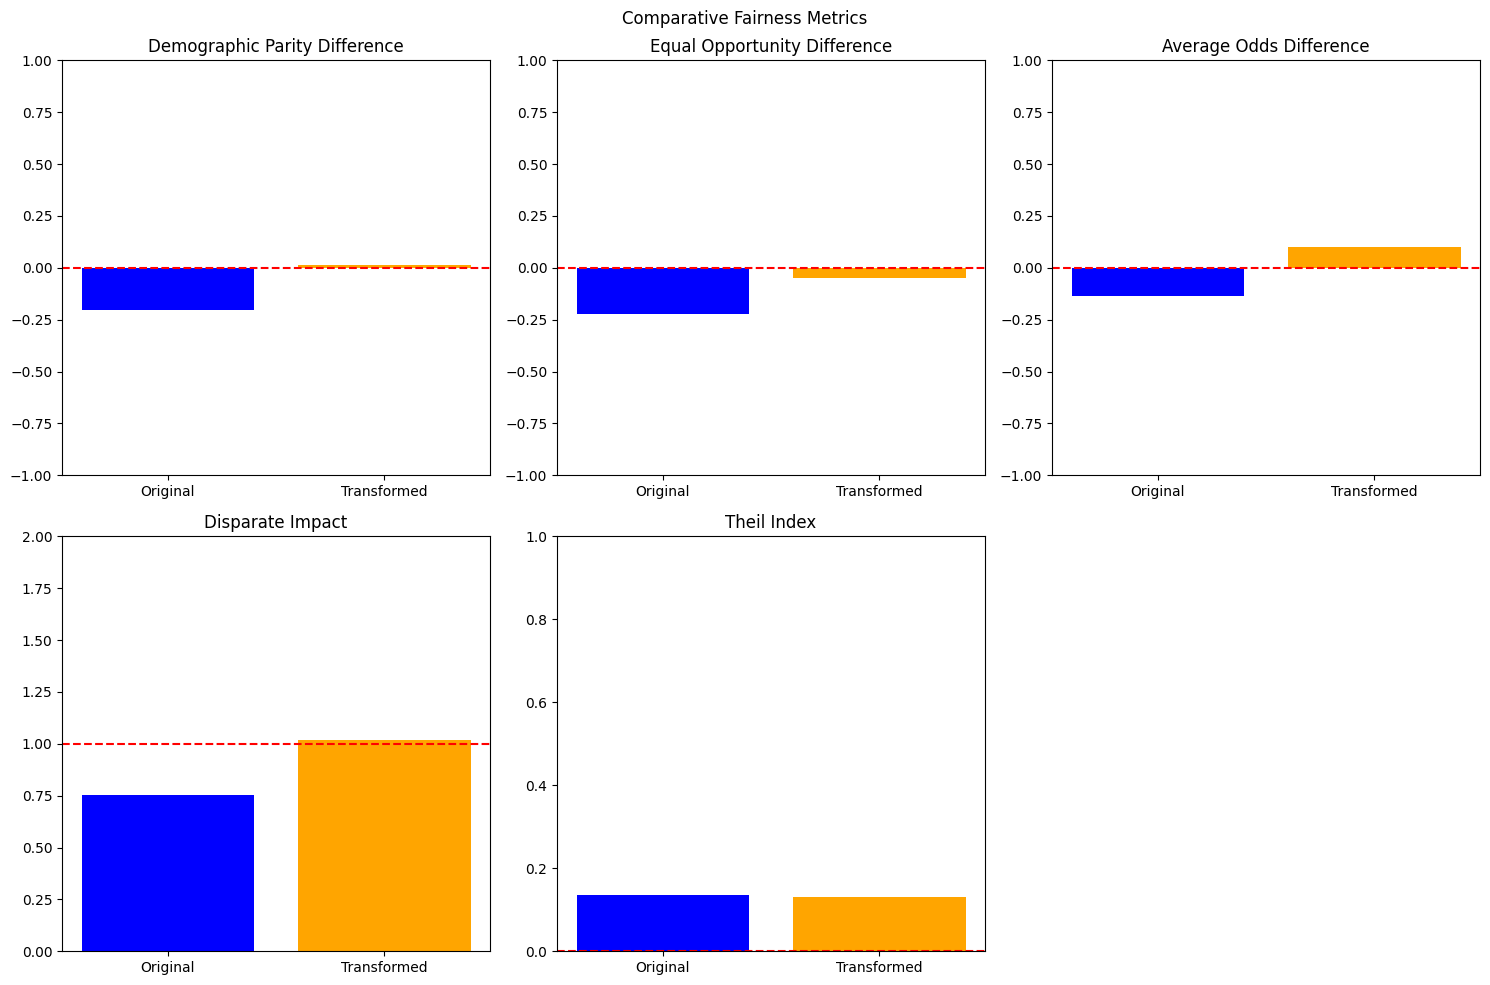

In [38]:
plot_comparative_fairness_metrics(fairness_metrics_lr_val, fairness_metrics_lr_rw_val)

#### Analysis

Comparing fairness metrics between the original and transformed data for Logistic Regression on the validation set:

- **Demographic Parity Difference** improved from **-0.203** to **0.014**, indicating that the transformed model provides nearly equal favorable outcomes across age groups.
- **Equal Opportunity Difference** decreased from **-0.224** to **-0.048**, showing a significant reduction in bias against the younger group.
- **Average Odds Difference** shifted from **-0.136** to **0.102**, suggesting improved fairness.
- **Disparate Impact** moved from **0.752** to **1.018**, indicating nearly equal treatment across groups.
- **Theil Index** slightly improved from **0.136** to **0.132**, reflecting reduced inequality.

Overall, the transformed data shows a significant improvement in fairness, reducing bias against younger individuals and achieving more balanced outcomes.

#### 4.3.3. Testing  LR model after reweighing

In [39]:
test_pred_rw_lr = lr_transf_model.predict(dataset_orig_test.features)
test_accuracy_rw_lr = accuracy_score(dataset_orig_test.labels, test_pred_rw_lr)
display(Markdown("#### Performance Metrics for LR model on transformed test data"))
print(f"Test Accuracy: {test_accuracy_rw_lr:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_test.labels, test_pred_rw_lr))

#### Performance Metrics for LR model on transformed test data

Test Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

         1.0       0.77      0.89      0.83       137
         2.0       0.64      0.43      0.51        63

    accuracy                           0.74       200
   macro avg       0.71      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



In [40]:
fairness_metrics_lr_rw_test = perform_bias_detection(dataset_orig_test, lr_transf_model, "LR Transf Test data")

#### Fairness Metrics for LR Transf Test data

Demographic Parity Difference: 0.029
Equal Opportunity Difference: -0.066
Average Odds Difference: 0.087
Disparate Impact: 1.036
Theil Index: 0.126


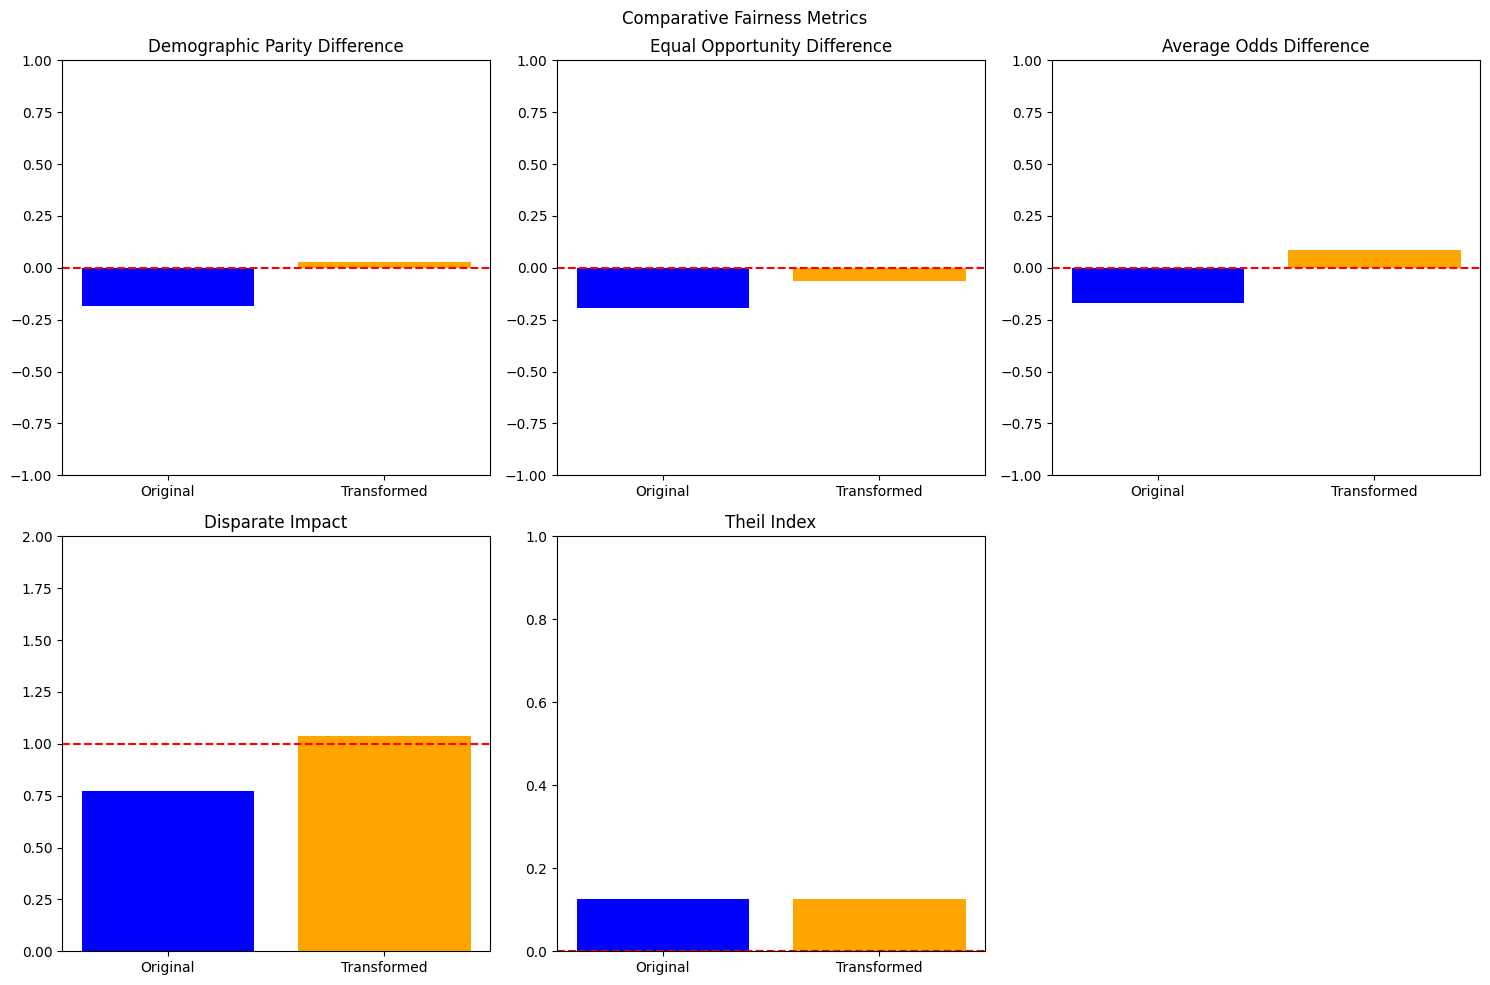

In [41]:
plot_comparative_fairness_metrics(fairness_metrics_lr_test, fairness_metrics_lr_rw_test)

#### Analysis

Comparing fairness metrics between the original and transformed data for Logistic Regression on the test set:

- **Demographic Parity Difference** improved from **-0.185** to **0.029**, indicating more equal favorable outcomes across age groups.
- **Equal Opportunity Difference** decreased from **-0.194** to **-0.066**, showing reduced bias against the younger group.
- **Average Odds Difference** improved from **-0.171** to **0.087**, suggesting a more balanced prediction.
- **Disparate Impact** increased from **0.773** to **1.036**, indicating near-equal treatment across groups.
- **Theil Index** remained consistent at **0.126**, indicating stable inequality.

Overall, the transformed data significantly improves fairness, reducing age-related bias and achieving more equitable outcomes between age groups.

### 4.4. Applying a Random Forest (RF) classifier on data transformed by reweighing

#### 4.4.1. Training  RF model after reweighing

In [42]:
dataset = dataset_transf_train
rf_model = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=1, random_state=42)
fit_params_transf_rf = {'randomforestclassifier__sample_weight': dataset.instance_weights}

rf_transf_model = train_model(dataset, rf_model, fit_params_transf_rf)

#### 4.4.2. Validating  RF model after reweighing

In [43]:
val_pred_rw_rf = rf_transf_model.predict(dataset_orig_val.features)
accuracy_rw_rf = accuracy_score(dataset_orig_val.labels, val_pred_rw_rf)
display(Markdown("#### Performance Metrics for RF model on transformed validation data"))    
print(f"Validation Accuracy: {accuracy_rw_rf:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_val.labels, val_pred_rw_rf))

#### Performance Metrics for RF model on transformed validation data

Validation Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

         1.0       0.77      0.93      0.85       213
         2.0       0.67      0.33      0.45        87

    accuracy                           0.76       300
   macro avg       0.72      0.63      0.65       300
weighted avg       0.75      0.76      0.73       300



In [44]:
fairness_metrics_rf_rw_val = perform_bias_detection(dataset_orig_val, rf_transf_model, "RF Transf Val data")

#### Fairness Metrics for RF Transf Val data

Demographic Parity Difference: -0.072
Equal Opportunity Difference: -0.061
Average Odds Difference: -0.020
Disparate Impact: 0.917
Theil Index: 0.097


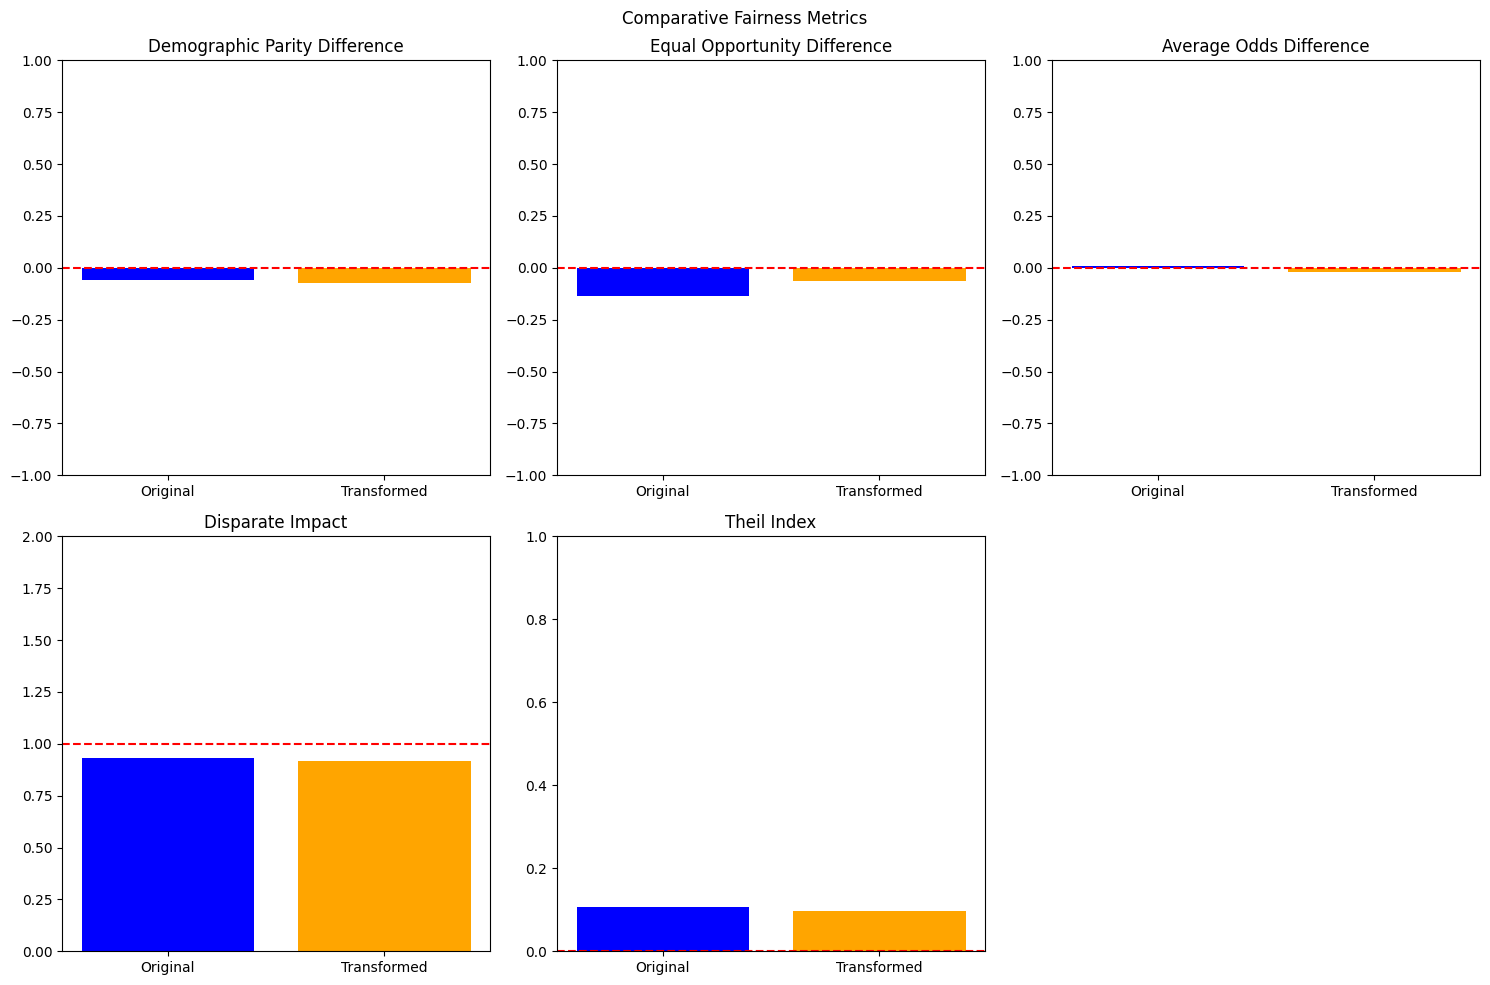

In [45]:
plot_comparative_fairness_metrics(fairness_metrics_rf_val, fairness_metrics_rf_rw_val)

#### Analysis

Comparing fairness metrics between the original and transformed data for Random Forest on the validation set:

- **Demographic Parity Difference** slightly worsened from **-0.060** to **-0.072**, indicating a minor increase in bias against younger individuals.
- **Equal Opportunity Difference** improved from **-0.136** to **-0.061**, showing better treatment for the unprivileged group.
- **Average Odds Difference** moved from **0.010** to **-0.020**, indicating a slight shift but still near balance.
- **Disparate Impact** decreased from **0.930** to **0.917**, suggesting a minor increase in disparity.
- **Theil Index** improved from **0.108** to **0.097**, reflecting reduced inequality.

Overall, the transformed data shows mixed results: slight improvements in equality of opportunity and overall inequality but a minor increase in demographic parity bias.

#### 4.4.3. Testing RF model after reweighing

In [46]:
test_pred_rw_rf = rf_transf_model.predict(dataset_orig_test.features)
test_accuracy_rw_rf = accuracy_score(dataset_orig_test.labels, test_pred_rw_rf)
display(Markdown("#### Performance Metrics for RF model on transformed test data"))
print(f"Validation Accuracy: {test_accuracy_rw_rf:.2f}")
print("Classification Report:")
print(classification_report(dataset_orig_test.labels, test_pred_rw_rf))

#### Performance Metrics for RF model on transformed test data

Validation Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

         1.0       0.77      0.93      0.84       137
         2.0       0.72      0.41      0.53        63

    accuracy                           0.77       200
   macro avg       0.75      0.67      0.68       200
weighted avg       0.76      0.77      0.74       200



In [47]:
fairness_metrics_rf_rw_test = perform_bias_detection(dataset_orig_test, rf_transf_model, "RF Transf Test data")

#### Fairness Metrics for RF Transf Test data

Demographic Parity Difference: -0.177
Equal Opportunity Difference: -0.108
Average Odds Difference: -0.202
Disparate Impact: 0.790
Theil Index: 0.099


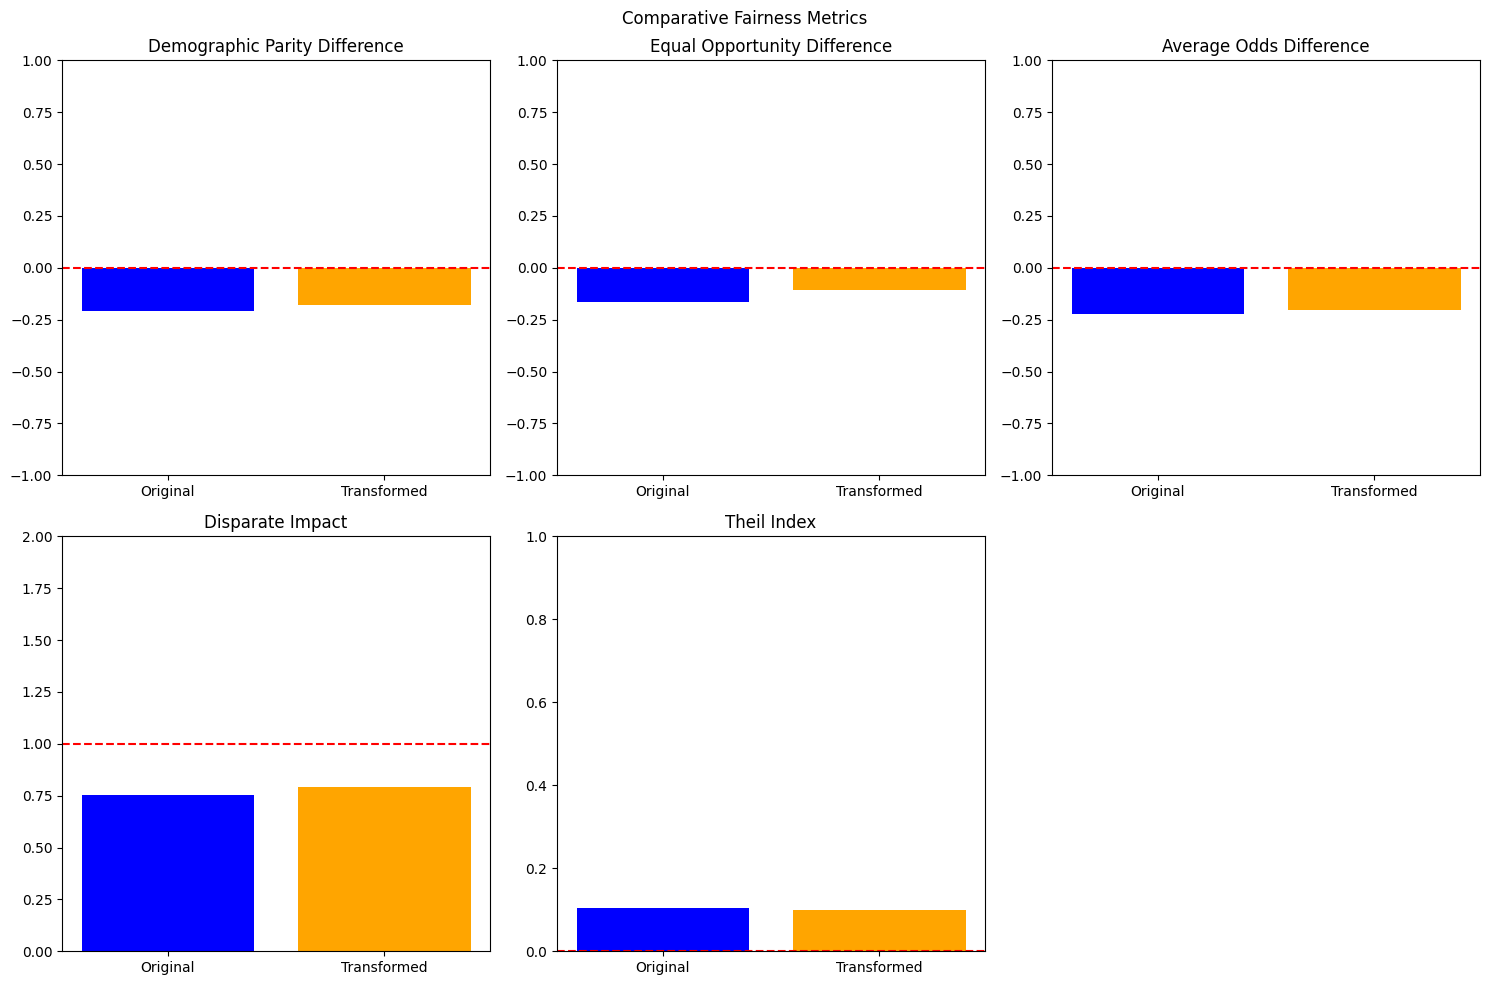

In [48]:
plot_comparative_fairness_metrics(fairness_metrics_rf_test, fairness_metrics_rf_rw_test)

#### Analysis

Comparing fairness metrics between the original and transformed data for Random Forest on the test set:

- **Demographic Parity Difference** improved from **-0.209** to **-0.177**, indicating a reduction in bias against younger individuals.
- **Equal Opportunity Difference** decreased from **-0.163** to **-0.108**, reflecting better accuracy for the unprivileged group.
- **Average Odds Difference** slightly improved from **-0.221** to **-0.202**, showing a small reduction in bias.
- **Disparate Impact** increased from **0.751** to **0.790**, indicating more equitable treatment.
- **Theil Index** improved from **0.104** to **0.099**, reflecting reduced inequality.

Overall, the transformed data shows moderate improvements in fairness, reducing age-related bias and achieving more balanced outcomes.

## [5.](#Table-of-Contents) Summary of Model Learning Results

In [85]:
def extract_metrics(method, classifier_name, fairness_metrics, accuracy):
    """
    Extract metrics for a given model and dataset, then return them as a DataFrame.

    Parameters:
    - method: The bias mitigation method applied (e.g., 'Without Mitigation', 'Reweighing').
    - classifier_name: The name of the classifier (e.g., 'Logistic Regression', 'Random Forest').
    - fairness_metrics: A dictionary containing fairness metrics of the method on the test dataset.
    - accuracy: The accuracy of the classifier on the test dataset.

    Returns:
    - df_metrics: A pandas DataFrame containing the extracted metrics.
    """

    # Define columns for the DataFrame
    columns = [
        'Bias Mitigation Method', 'Classifier', 'Accuracy', 
        'Diff Parity Diff', 'Eq Opp Diff', 
        'Avg Odds Diff', 'Disparate Impact', 'Theil Index'
    ]

    # Create a DataFrame with the extracted metrics
    df_metrics = pd.DataFrame([{
        'Bias Mitigation Method': method,
        'Classifier': classifier_name,
        'Accuracy': f'{accuracy:.2f}',
        'Diff Parity Diff': fairness_metrics.get("Demographic Parity Difference", None),
        'Eq Opp Diff': fairness_metrics.get("Equal Opportunity Difference", None),
        'Avg Odds Diff': fairness_metrics.get("Average Odds Difference", None),
        'Disparate Impact': fairness_metrics.get("Disparate Impact", None),
        'Theil Index': fairness_metrics.get("Theil Index", None)
    }], columns=columns)

    return df_metrics

In [86]:
# Initialize an empty list to store DataFrames
metrics_dfs = []

# Extracting metrics for different classifiers and methods
metrics_dfs.append(extract_metrics('Without Mitigation', 'Logistic Regression', fairness_metrics_lr_test, test_accuracy_lr))
metrics_dfs.append(extract_metrics('Without Mitigation', 'Random Forest', fairness_metrics_rf_test, test_accuracy_rf))
metrics_dfs.append(extract_metrics('Reweighing', 'Logistic Regression', fairness_metrics_lr_rw_test, test_accuracy_rw_lr))
metrics_dfs.append(extract_metrics('Reweighing', 'Random Forest', fairness_metrics_rf_rw_test, test_accuracy_rw_rf))

# Combine all the individual DataFrames into one
combined_df = pd.concat(metrics_dfs, ignore_index=True)

combined_df


,Bias Mitigation Method,Classifier,Accuracy,Diff Parity Diff,Eq Opp Diff,Avg Odds Diff,Disparate Impact,Theil Index
0,Without Mitigation,Logistic Regression,0.74,-0.185399,-0.193744,-0.170946,0.772524,0.125976
1,Without Mitigation,Random Forest,0.77,-0.208521,-0.163399,-0.220588,0.751213,0.104024
2,Reweighing,Logistic Regression,0.74,0.028688,-0.065826,0.087457,1.036492,0.125976
3,Reweighing,Random Forest,0.77,-0.177264,-0.107843,-0.202070,0.789954,0.099327


#### Analysis

In the provided table, Random Forest generally outperforms Logistic Regression in terms of accuracy, with both bias mitigation methods resulting in an accuracy of 0.77 for Random Forest and 0.74 for Logistic Regression. Reweighing improves fairness metrics, as seen with Logistic Regression achieving a positive Disparate Impact (1.036), suggesting better balance in outcomes across groups. However, Random Forest under Reweighing still shows slightly lower disparities (e.g., -0.108 in Equal Opportunity Difference) with comparable accuracy. Overall, Reweighing with Random Forest provides a balanced trade-off between accuracy and fairness, making it the better choice for this study.

## [6.](#Table-of-Contents) Conclusion

In this project, we explored the critical issue of age bias in credit decision-making models, demonstrating both detection and mitigation strategies. By analyzing the German Credit dataset, we identified significant disparities in how different age groups were treated by machine learning models. Through the application of various fairness metrics, such as Disparate Impact and Equal Opportunity Difference, we were able to quantify the extent of this bias.

To address these biases, we employed the Reweighing technique, a pre-processing method designed to balance the dataset by adjusting the weights of instances based on their group membership. The results showed a noticeable reduction in bias, as reflected in improved fairness metrics, without significantly compromising model accuracy.

This study underscores the importance of integrating fairness considerations into the machine learning workflow, especially in high-stakes domains like credit scoring. By systematically detecting and mitigating bias, organizations can ensure more equitable decision-making processes, promoting fairness and compliance with ethical and legal standards. Moving forward, continuous monitoring and refinement of these models are essential to maintaining fairness as the data and societal contexts evolve.